# Task 4 a: Utilization Prediction using Neural Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras import Sequential
from keras.layers import Dense, Dropout

%matplotlib inline

### Cross validation and normalizing

We will perform the predictions for site 1 and site 2 separately, because they have different characteristics. 
The random state parameter means that the cross validation is reproducible and can be performed in the same way for the prediction using polynomial regression and neural networks.

In [2]:
# read in the preprocessed data
Input_hourly = pd.read_csv('input_hourly.csv', parse_dates=['date'])

# split into input and output
X_site1 = Input_hourly.drop(["time_id", "date", "site1_utilization_percentage", "site2_utilization_percentage"], axis=1)
y_site1 = Input_hourly["site1_utilization_percentage"]

X_site2 = Input_hourly.drop(["time_id", "date", "site1_utilization_percentage", "site2_utilization_percentage"], axis=1)
y_site2 = Input_hourly["site2_utilization_percentage"]

# cross-validation
X_train_site1, X_test_site1, y_train_site1, y_test_site1 = train_test_split(X_site1, y_site1, test_size=0.3, random_state=42)

X_train_site2, X_test_site2, y_train_site2, y_test_site2 = train_test_split(X_site2, y_site2, test_size=0.3, random_state=42)

# normalize the data, save the original values and delete columns that are not needed as input
X_train_site1_original = X_train_site1.copy()
X_test_site1_original = X_test_site1.copy()

X_train_site1 = X_train_site1.drop(["hour", "month", "dayOfTheWeek"], axis=1)
X_test_site1 = X_test_site1.drop(["hour", "month", "dayOfTheWeek"], axis=1)

scaler_site1 = StandardScaler()
scaler_site1.fit(X_train_site1)

X_train_site1 = scaler_site1.transform(X_train_site1)
X_test_site1 = scaler_site1.transform(X_test_site1)

X_train_site2_original = X_train_site2.copy()
X_test_site2_original = X_test_site2.copy()

X_train_site2 = X_train_site2.drop(["hour", "month", "dayOfTheWeek"], axis=1)
X_test_site2 = X_test_site2.drop(["hour", "month", "dayOfTheWeek"], axis=1)

scaler_site2 = StandardScaler()
scaler_site2.fit(X_train_site2)

X_train_site2 = scaler_site2.transform(X_train_site2)
X_test_site2 = scaler_site2.transform(X_test_site2)

## Utilization prediction of site 1

### Model definition (site 1)

In [3]:
model_site1 = Sequential(
    [Dense(36, activation="relu", input_shape=[X_train_site1.shape[1]]),
    Dense(36, activation="relu"),
     Dense(1)])
model_site1.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])
model_site1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36)                1656      
                                                                 
 dense_1 (Dense)             (None, 36)                1332      
                                                                 
 dense_2 (Dense)             (None, 1)                 37        
                                                                 
Total params: 3,025
Trainable params: 3,025
Non-trainable params: 0
_________________________________________________________________


### Training the model (site 1)

Epoch 1/20
215/215 [==============================] - 2s 5ms/step - loss: 507.5120 - mae: 13.8389 - mse: 507.5120 - val_loss: 241.2889 - val_mae: 10.9004 - val_mse: 241.2889
Epoch 2/20
215/215 [==============================] - 1s 3ms/step - loss: 150.1364 - mae: 7.7912 - mse: 150.1364 - val_loss: 133.9382 - val_mae: 7.0689 - val_mse: 133.9382
Epoch 3/20
215/215 [==============================] - 1s 3ms/step - loss: 109.1138 - mae: 6.0206 - mse: 109.1138 - val_loss: 121.1337 - val_mae: 6.4075 - val_mse: 121.1337
Epoch 4/20
215/215 [==============================] - 1s 3ms/step - loss: 99.6863 - mae: 5.4013 - mse: 99.6863 - val_loss: 111.9140 - val_mae: 5.7706 - val_mse: 111.9140
Epoch 5/20
215/215 [==============================] - 1s 3ms/step - loss: 96.1490 - mae: 5.0485 - mse: 96.1490 - val_loss: 109.9919 - val_mae: 5.4850 - val_mse: 109.9919
Epoch 6/20
215/215 [==============================] - 1s 3ms/step - loss: 94.5402 - mae: 4.8008 - mse: 94.5402 - val_loss: 109.2769 - val_mae:

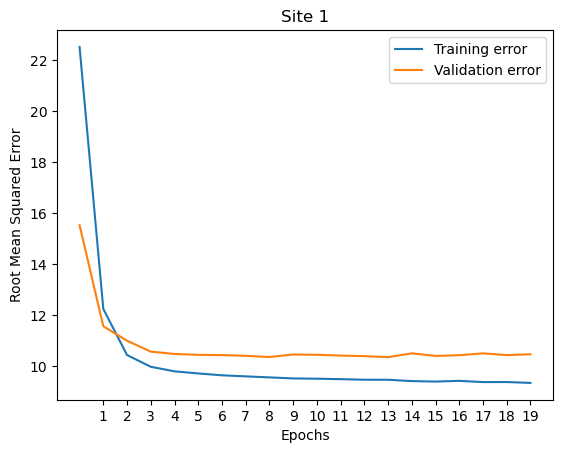

In [4]:
epochs_site1 = 20

# train the model
history_site1 = model_site1.fit(X_train_site1, y_train_site1.values,
                   epochs=epochs_site1, validation_split=0.2)
history_site1 = pd.DataFrame(history_site1.history)

# compute rmse
root_metrics_site1 = history_site1[["mse", "val_mse"]].apply(np.sqrt)
root_metrics_site1.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)

# plot rmse of the training and validation set per epoch
plt.Figure(figsize=(14,6), dpi=100)
plt.plot(root_metrics_site1["rmse"], label = 'Training error')
plt.plot(root_metrics_site1["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.title("Site 1")

plt.xticks(range(1,20))
plt.legend()

plt.show()

### Prediction (site 1)

In [5]:
# prediction using the trained model
y_pred_site1 = model_site1.predict(X_test_site1)

115/115 [==============================] - 1s 2ms/step


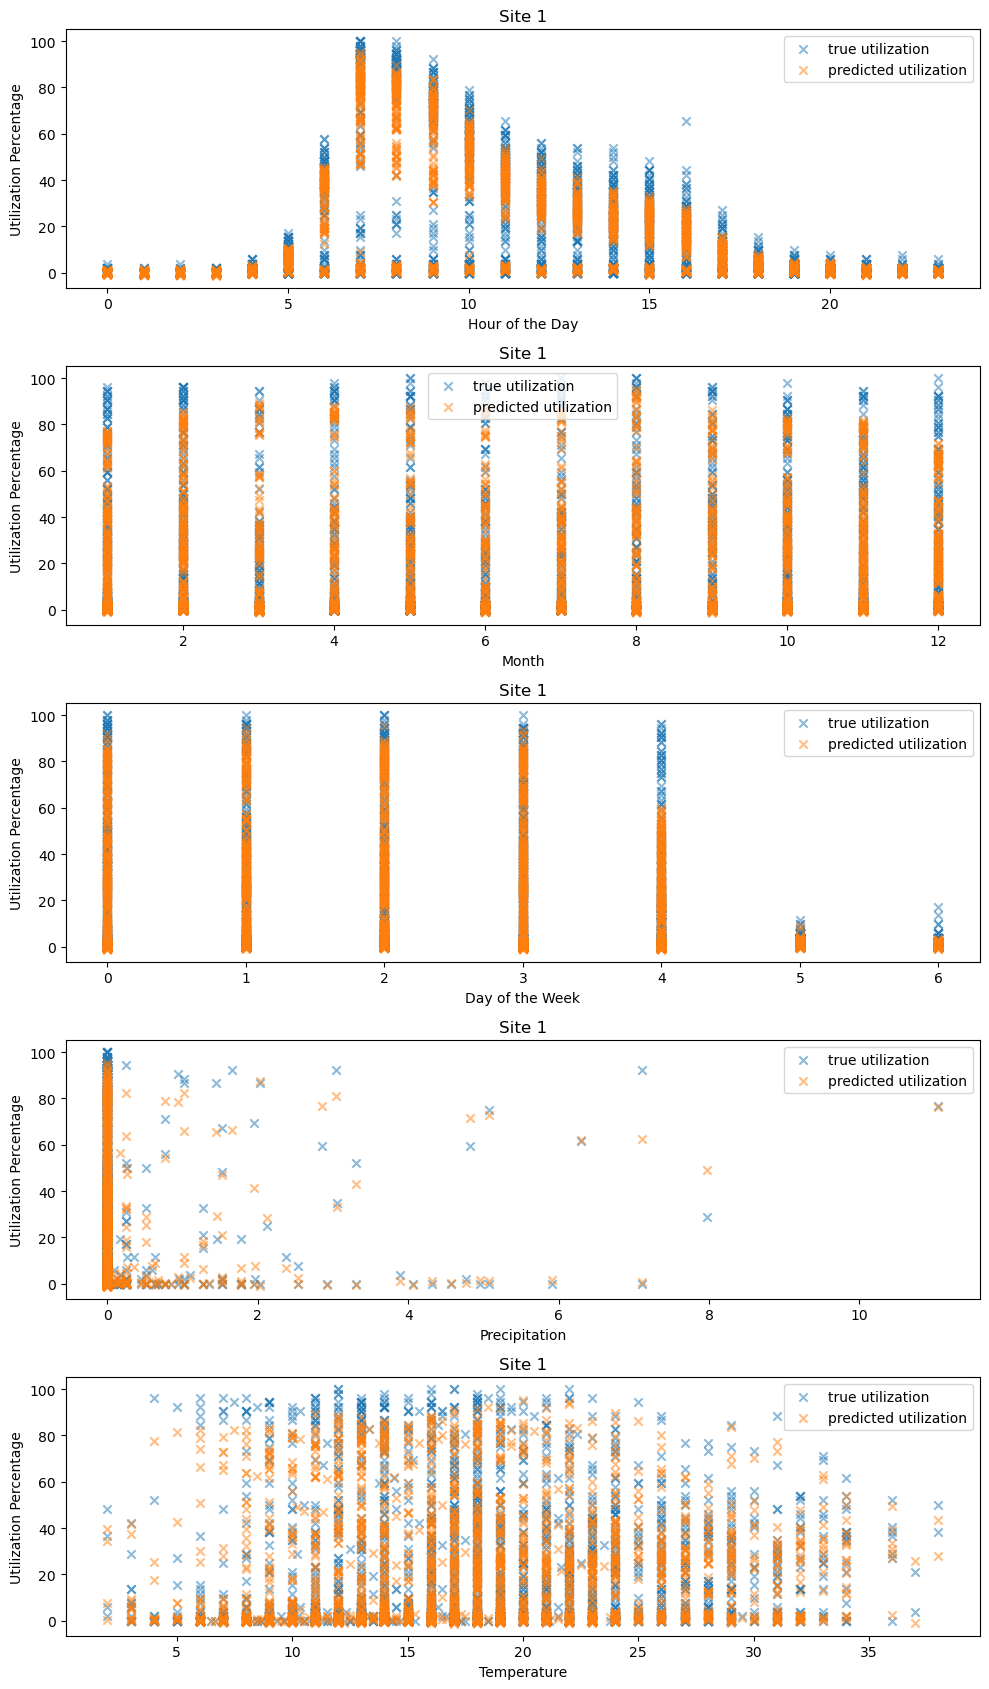

In [6]:
# subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 17), sharey=True)

# hour
axs[0].scatter(X_test_site1_original['hour'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[0].scatter(X_test_site1_original['hour'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[0].set_title('Site 1')
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Utilization Percentage')

# month
axs[1].scatter(X_test_site1_original['month'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[1].scatter(X_test_site1_original['month'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[1].set_title('Site 1')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Utilization Percentage')

# dayOfTheWeek
axs[2].scatter(X_test_site1_original['dayOfTheWeek'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[2].scatter(X_test_site1_original['dayOfTheWeek'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[2].set_title('Site 1')
axs[2].set_xlabel('Day of the Week')
axs[2].set_ylabel('Utilization Percentage')

# precipitation
axs[3].scatter(X_test_site1_original['precipitation'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[3].scatter(X_test_site1_original['precipitation'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[3].set_title('Site 1')
axs[3].set_xlabel('Precipitation')
axs[3].set_ylabel('Utilization Percentage')

# temperature
axs[4].scatter(X_test_site1_original['temperature'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[4].scatter(X_test_site1_original['temperature'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[4].set_title('Site 1')
axs[4].set_xlabel('Temperature')
axs[4].set_ylabel('Utilization Percentage')

# legend
for ax in axs.flat:
    ax.legend()

# layout
plt.tight_layout()
plt.show()

The features that influence the utilization the most are whether ist a weekday or the weekend and the hour. Therefore we look at these features in detail.

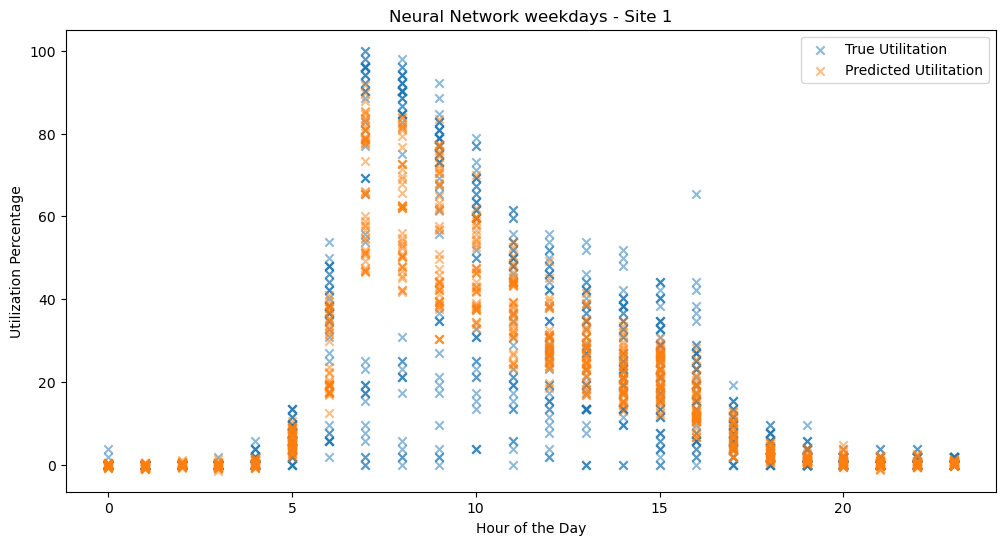

In [7]:
all_values = X_test_site1_original
all_values["true_utilization"] = y_test_site1
all_values["predicted_values"] = y_pred_site1
weekday_values = all_values[all_values['dayOfTheWeek'].isin([0, 4])]

plt.figure(figsize=(12, 6))
plt.scatter(weekday_values['hour'], weekday_values["true_utilization"], label='True Utilitation', marker='x', alpha=0.5)
plt.scatter(weekday_values['hour'], weekday_values["predicted_values"], label='Predicted Utilitation', marker='x', alpha=0.5)

plt.xlabel('Hour of the Day')
plt.ylabel('Utilization Percentage')
plt.title('Neural Network weekdays - Site 1')
plt.legend()

plt.show()

### Evaluation (site 1)

In [8]:
print("RMSE: ", np.sqrt(mean_squared_error(y_test_site1, y_pred_site1)))
print("MAE: ", mean_absolute_error(y_test_site1, y_pred_site1))
print("MAPE: ", mean_absolute_percentage_error(y_test_site1, y_pred_site1))

RMSE:  9.971598426571616
MAE:  4.8306080730667365
MAPE:  3155342687859320.5


## Utilization prediction of site 2

### Model definition (site 2)

In [9]:
model_site2 = Sequential(
    [Dense(36, activation="relu", input_shape=[X_train_site2.shape[1]]),
    Dense(36, activation="relu"),
     Dense(1)])
model_site2.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])
model_site2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 36)                1656      
                                                                 
 dense_4 (Dense)             (None, 36)                1332      
                                                                 
 dense_5 (Dense)             (None, 1)                 37        
                                                                 
Total params: 3,025
Trainable params: 3,025
Non-trainable params: 0
_________________________________________________________________


### Training the model (site 2)

Epoch 1/20
215/215 [==============================] - 1s 4ms/step - loss: 85.9902 - mae: 5.6553 - mse: 85.9902 - val_loss: 40.7273 - val_mae: 4.3167 - val_mse: 40.7273
Epoch 2/20
215/215 [==============================] - 1s 3ms/step - loss: 38.4377 - mae: 3.9962 - mse: 38.4377 - val_loss: 31.1422 - val_mae: 3.6021 - val_mse: 31.1422
Epoch 3/20
215/215 [==============================] - 1s 3ms/step - loss: 34.1843 - mae: 3.6270 - mse: 34.1843 - val_loss: 29.4981 - val_mae: 3.4192 - val_mse: 29.4981
Epoch 4/20
215/215 [==============================] - 1s 3ms/step - loss: 32.8575 - mae: 3.5096 - mse: 32.8575 - val_loss: 28.7913 - val_mae: 3.3665 - val_mse: 28.7913
Epoch 5/20
215/215 [==============================] - 1s 3ms/step - loss: 32.2367 - mae: 3.4517 - mse: 32.2367 - val_loss: 28.3513 - val_mae: 3.3138 - val_mse: 28.3513
Epoch 6/20
215/215 [==============================] - 1s 3ms/step - loss: 31.6339 - mae: 3.4102 - mse: 31.6339 - val_loss: 28.3036 - val_mae: 3.3290 - val_mse: 

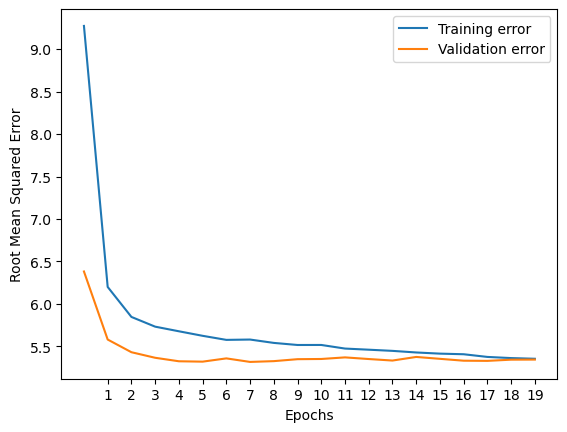

In [10]:
epochs_site2 = 20

# train the model
history_site2 = model_site2.fit(X_train_site2, y_train_site2.values,
                   epochs=epochs_site2, validation_split=0.2)
history_site2 = pd.DataFrame(history_site2.history)

# compute rmse
root_metrics_site2 = history_site2[["mse", "val_mse"]].apply(np.sqrt)
root_metrics_site2.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)

# plot rmse of the training and validation set per epoch
plt.Figure(figsize=(14,6), dpi=100)
plt.plot(root_metrics_site2["rmse"], label = 'Training error')
plt.plot(root_metrics_site2["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

plt.xticks(range(1,20))
plt.legend()

plt.show()

### Prediction (site 2)

In [11]:
# prediction using the trained model
y_pred_site2 = model_site2.predict(X_test_site2)

115/115 [==============================] - 0s 2ms/step


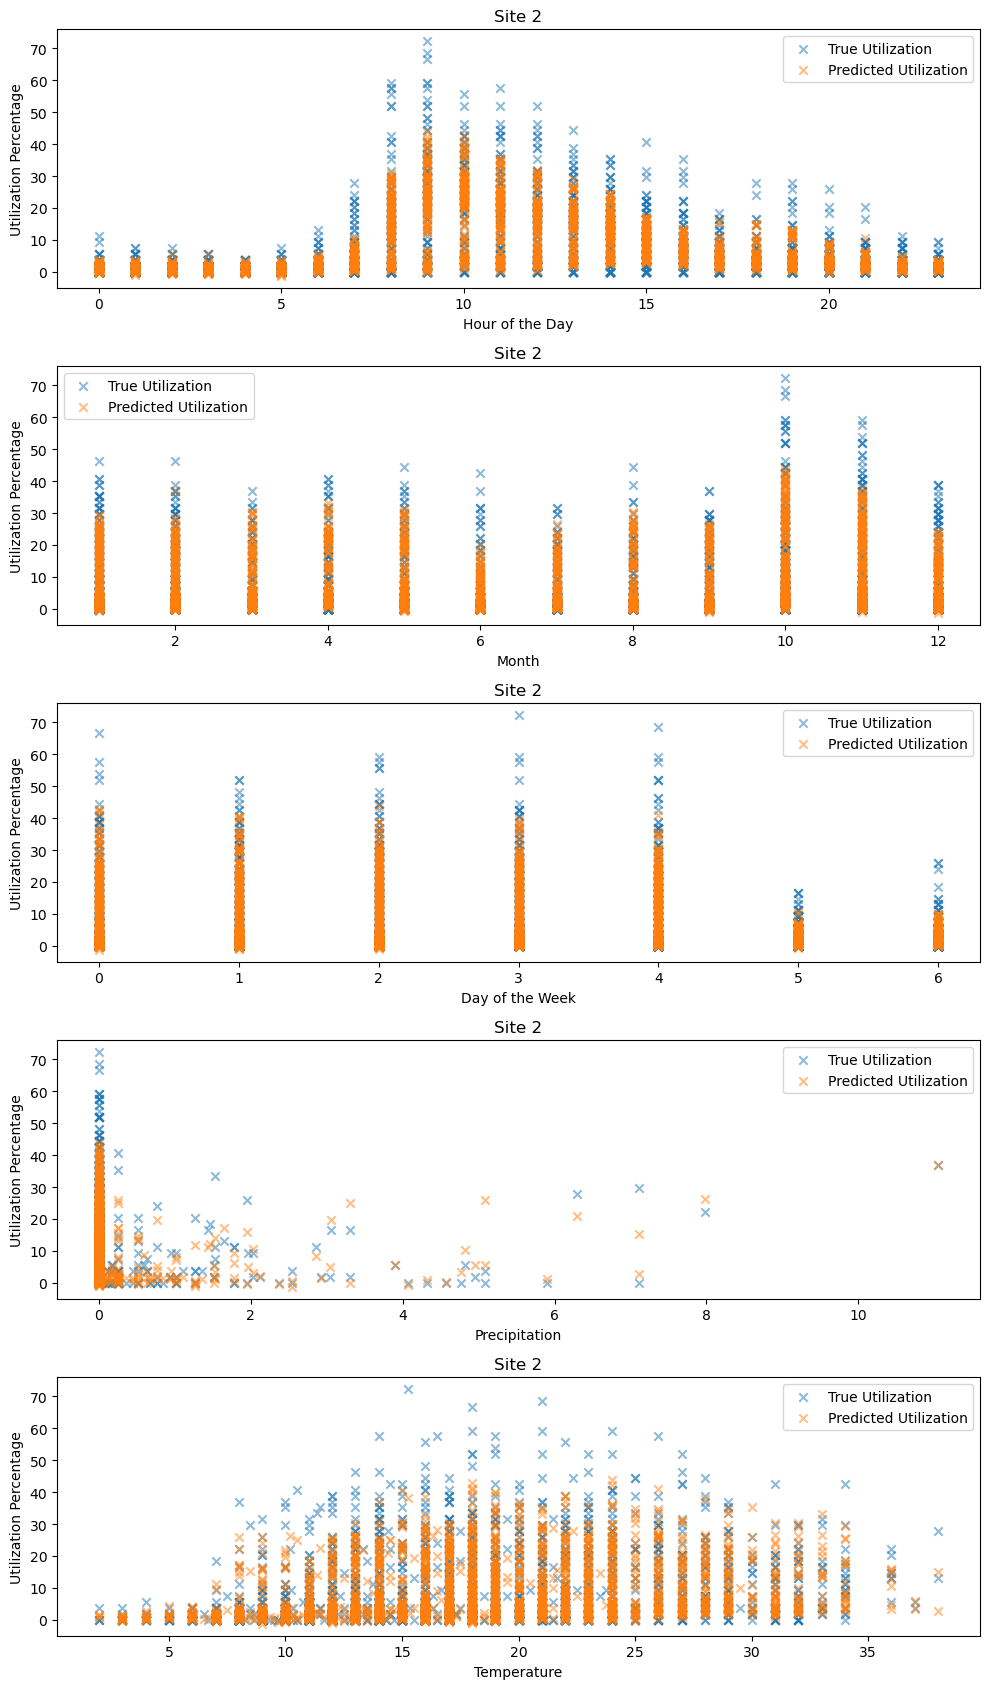

In [12]:
# subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 17), sharey=True)

# hour
axs[0].scatter(X_test_site2_original['hour'], y_test_site2, label='True Utilization', marker='x', alpha=0.5)
axs[0].scatter(X_test_site2_original['hour'], y_pred_site2, label='Predicted Utilization', marker='x', alpha=0.5)
axs[0].set_title('Site 2')
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Utilization Percentage')

# month
axs[1].scatter(X_test_site2_original['month'], y_test_site2, label='True Utilization', marker='x', alpha=0.5)
axs[1].scatter(X_test_site2_original['month'], y_pred_site2, label='Predicted Utilization', marker='x', alpha=0.5)
axs[1].set_title('Site 2')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Utilization Percentage')

# dayOfTheWeek
axs[2].scatter(X_test_site2_original['dayOfTheWeek'], y_test_site2, label='True Utilization', marker='x', alpha=0.5)
axs[2].scatter(X_test_site2_original['dayOfTheWeek'], y_pred_site2, label='Predicted Utilization', marker='x', alpha=0.5)
axs[2].set_title('Site 2')
axs[2].set_xlabel('Day of the Week')
axs[2].set_ylabel('Utilization Percentage')

# precipitation
axs[3].scatter(X_test_site2_original['precipitation'], y_test_site2, label='True Utilization', marker='x', alpha=0.5)
axs[3].scatter(X_test_site2_original['precipitation'], y_pred_site2, label='Predicted Utilization', marker='x', alpha=0.5)
axs[3].set_title('Site 2')
axs[3].set_xlabel('Precipitation')
axs[3].set_ylabel('Utilization Percentage')

# temperature
axs[4].scatter(X_test_site2_original['temperature'], y_test_site2, label='True Utilization', marker='x', alpha=0.5)
axs[4].scatter(X_test_site2_original['temperature'], y_pred_site2, label='Predicted Utilization', marker='x', alpha=0.5)
axs[4].set_title('Site 2')
axs[4].set_xlabel('Temperature')
axs[4].set_ylabel('Utilization Percentage')

# legend
for ax in axs.flat:
    ax.legend()

# layout
plt.tight_layout()
plt.show()

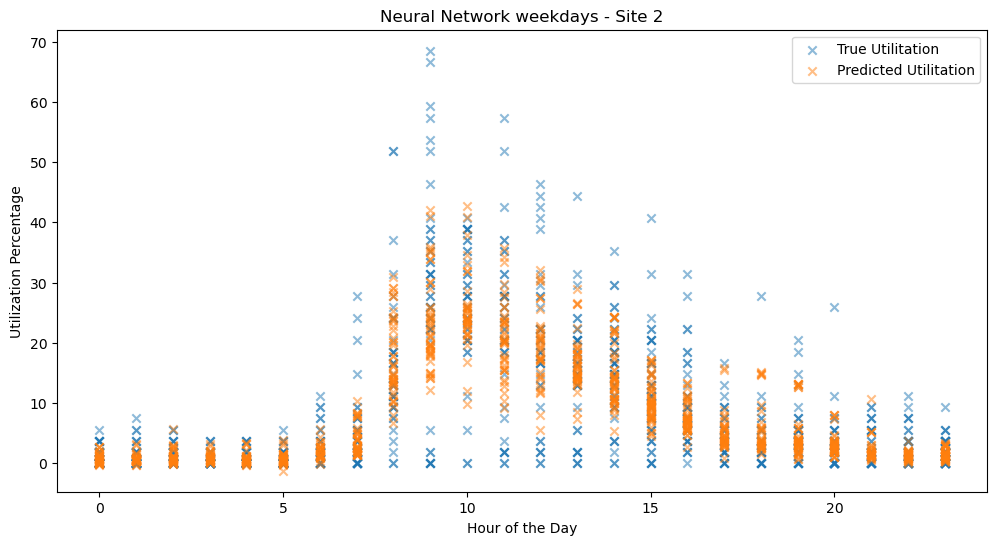

In [13]:
all_values = X_test_site2_original
all_values["true_utilization"] = y_test_site2
all_values["predicted_values"] = y_pred_site2
weekday_values = all_values[all_values['dayOfTheWeek'].isin([0, 4])]

plt.figure(figsize=(12, 6))
plt.scatter(weekday_values['hour'], weekday_values["true_utilization"], label='True Utilitation', marker='x', alpha=0.5)
plt.scatter(weekday_values['hour'], weekday_values["predicted_values"], label='Predicted Utilitation', marker='x', alpha=0.5)

plt.xlabel('Hour of the Day')
plt.ylabel('Utilization Percentage')
plt.title('Neural Network weekdays - Site 2')
plt.legend()

plt.show()

### Evaluation (site 2)

In [14]:
print("RMSE: ", np.sqrt(mean_squared_error(y_test_site2, y_pred_site2)))
print("MAE: ", mean_absolute_error(y_test_site2, y_pred_site2))
print("MAPE: ", mean_absolute_percentage_error(y_test_site2, y_pred_site2))

RMSE:  5.486051556995358
MAE:  3.3855417078022283
MAPE:  2892142626634249.5
